In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

# NLP Imports
import regex as re
from bs4 import BeautifulSoup
import string
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob, Word
from sklearn.feature_extraction import text
from wordcloud import WordCloud, ImageColorGenerator
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Other Imports
import janitor
from datetime import datetime
from dateutil import parser

# Ignore warnings
import warnings
def ignore_warn(*args,**kwargs):
    pass
warnings.warn=ignore_warn

In [2]:
path = 'data/chats/sample_1.txt'

In [3]:
def read_history(file):
    string = open(file).read()
    new_str = re.sub('\[',"",string)
    new_str = re.sub('\]',"",string)
    #f = open('data/{}'.format(file), 'r')
    #f = open(file,'r') 
    # Every text message has the same format: date - sender: message. 
    messages = re.findall('(\d+/\d+/\d+, \d+:\d+:\d+ [A-Z]*) (.*?): (.*)', new_str)

    #Convert list to a dataframe and name the columns
    history = pd.DataFrame(messages,columns=['datetime','name','msg'])
    history['datetime'] = pd.to_datetime(history['datetime'],format="%d/%m/%y, %I:%M:%S %p")
    history['date'] = history['datetime'].apply(lambda x: x.date())

    # file is in the format 'WhatsApp Conversation with XXX.txt'
    history['conv_name'] = file[19:-4]

    return history

In [4]:
chat = read_history(path)

In [5]:
chat.columns

Index(['datetime', 'name', 'msg', 'date', 'conv_name'], dtype='object')

In [6]:
chat.shape

(121325, 5)

In [7]:
chat.drop(columns='conv_name')
chat.head()

,datetime,name,msg,date,conv_name
0,2018-03-21 09:47:16,👻,‎Messages and calls are end-to-end encrypted. ...,2018-03-21,
1,2018-03-21 09:47:16,A.,Hello 👋 where have you been? You fell sick?,2018-03-21,
2,2018-03-21 10:03:35,👻,"Hello, just taking some time off :) need to cl...",2018-03-21,
3,2018-04-12 11:19:34,A.,Hey! What time is lunch later?,2018-04-12,
4,2018-04-12 11:19:36,A.,12pm?,2018-04-12,


In [8]:
chat['msg'].value_counts()

‎sticker omitted                                 18111
‎image omitted                                    3383
Ok                                                1285
Haha                                               916
:(                                                 510
                                                 ...  
I meant, so empty                                    1
and the books don’t even make sense sometimes        1
I was jk                                             1
Normally I only reply one by one                     1
Are you going to reply?                              1
Name: msg, Length: 70299, dtype: int64

In [9]:
chat[chat['msg'].str.contains(r'^(?!.*sticker).*omitted')]

,datetime,name,msg,date,conv_name
195,2018-05-31 12:19:17,👻,‎image omitted,2018-05-31,
218,2018-06-06 19:08:23,👻,‎image omitted,2018-06-06,
286,2018-07-20 14:38:11,A.,‎Contact card omitted,2018-07-20,
497,2018-09-02 12:09:47,A.,‎image omitted,2018-09-02,
498,2018-09-02 12:09:47,A.,‎image omitted,2018-09-02,
...,...,...,...,...,...
121184,2020-09-21 11:15:09,A.,‎image omitted,2020-09-21,
121239,2020-09-21 21:03:00,A.,‎image omitted,2020-09-21,
121318,2020-09-22 13:30:57,A.,‎image omitted,2020-09-22,
121319,2020-09-22 13:30:57,A.,‎image omitted,2020-09-22,


In [10]:
index_omitted = chat[chat['msg'].str.match('^(?!.*sticker).*omitted')]
index_omitted_2 = chat[chat['msg'].str.contains(r'deleted this message|message was deleted|end-to-end encrypted')]

In [11]:
chat.drop(index=index_omitted.index,inplace=True)
chat.drop(index=index_omitted_2.index,inplace=True)
chat.reset_index(inplace = True) 

In [12]:
chat['msg'].value_counts()

‎sticker omitted                                 18111
Ok                                                1285
Haha                                               916
:(                                                 510
Hahaha                                             489
                                                 ...  
I meant, so empty                                    1
and the books don’t even make sense sometimes        1
I was jk                                             1
Normally I only reply one by one                     1
Are you going to reply?                              1
Name: msg, Length: 70280, dtype: int64

In [13]:
chat.shape

(117488, 6)

In [14]:
chat.describe()

,index
count,117488.000000
mean,60495.519338
std,35027.224256
min,1.000000
25%,30157.750000
50%,60464.500000
75%,90772.250000
max,121324.000000


In [15]:
party_names = chat['name'].unique().tolist()
party_names

['A.', '👻']

In [16]:
party_1 = party_names[0]
party_2 = party_names[1]
print(party_1)
print(party_2)     

A.
👻


In [17]:
msgcount_1 = chat[chat['name']==party_1]['msg'].count()
msgcount_2 = chat[chat['name']==party_2]['msg'].count()
print(f'Message Count by {party_1}: {msgcount_1}')
print(f'Message Count by {party_2}: {msgcount_2}')

Message Count by A.: 69412
Message Count by 👻: 48076


# Text Preprocessing

In [18]:
def remove_html(text):
    soup = BeautifulSoup(text,'lxml')
    html_free = soup.get_text()
    return html_free

def remove_punctuations(text):
    punc_free = "".join([w for w in text if w not in string.punctuation])
    #punc_free = text.strip('\u200e')
    return punc_free

def tokenize_text(text):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(text)

def word_lemmatizer(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(w) for w in text]
    return lemmatized

# Add stopwords here.
newStopWords = ['sticker','omitted']
stop_list = text.ENGLISH_STOP_WORDS.union(newStopWords)

def remove_stopwords(text):
    words = [w for w in text if w not in stop_list]
    return words

In [21]:
len(stop_list)

320

In [22]:
chat['msg_cleaned'] = chat['msg'].apply(lambda x: remove_punctuations(x)).apply(lambda x: remove_html(x))
chat.head()

,index,datetime,name,msg,date,conv_name,msg_cleaned
0,1,2018-03-21 09:47:16,A.,Hello 👋 where have you been? You fell sick?,2018-03-21,,Hello 👋 where have you been You fell sick
1,2,2018-03-21 10:03:35,👻,"Hello, just taking some time off :) need to cl...",2018-03-21,,Hello just taking some time off need to clear...
2,3,2018-04-12 11:19:34,A.,Hey! What time is lunch later?,2018-04-12,,Hey What time is lunch later
3,4,2018-04-12 11:19:36,A.,12pm?,2018-04-12,,12pm
4,5,2018-04-12 11:20:25,👻,Yeap,2018-04-12,,Yeap


In [23]:
chat['msg_token']= chat['msg_cleaned'].apply(lambda x: tokenize_text(x)).apply(lambda x: remove_stopwords(x)).apply(lambda x: word_lemmatizer(x))

In [24]:
#chat.head(10)

In [25]:
chat[chat['msg'].str.contains('sticker omitted')]['msg'][1587]

'\u200esticker omitted'

In [26]:
for i in chat['msg']:
    re.sub(r"\\u200e","",i)
    i.replace(r"\\u200e","")

In [27]:
chat[chat['msg'].str.contains('sticker omitted')]['msg'][1587]

'\u200esticker omitted'

In [28]:
chat['msg_len']=chat['msg_cleaned'].map(lambda x: len(set(x.split())))
chat.head()

,index,datetime,name,msg,date,conv_name,msg_cleaned,msg_token,msg_len
0,1,2018-03-21 09:47:16,A.,Hello 👋 where have you been? You fell sick?,2018-03-21,,Hello 👋 where have you been You fell sick,"[Hello, You, fell, sick]",9
1,2,2018-03-21 10:03:35,👻,"Hello, just taking some time off :) need to cl...",2018-03-21,,Hello just taking some time off need to clear...,"[Hello, just, taking, time, need, clear, leave...",13
2,3,2018-04-12 11:19:34,A.,Hey! What time is lunch later?,2018-04-12,,Hey What time is lunch later,"[Hey, What, time, lunch, later]",6
3,4,2018-04-12 11:19:36,A.,12pm?,2018-04-12,,12pm,[12pm],1
4,5,2018-04-12 11:20:25,👻,Yeap,2018-04-12,,Yeap,[Yeap],1


### Emoji Extraction

In [29]:
import emoji
def extract_emojis(str):
    return ''.join(c for c in str if c in emoji.UNICODE_EMOJI)

In [30]:
chat['emoji']=chat['msg_cleaned'].apply(lambda x: extract_emojis(x))
chat['emoji_count']=chat['emoji'].apply(lambda x: len(x))

In [31]:
chat.head()

,index,datetime,name,msg,date,conv_name,msg_cleaned,msg_token,msg_len,emoji,emoji_count
0,1,2018-03-21 09:47:16,A.,Hello 👋 where have you been? You fell sick?,2018-03-21,,Hello 👋 where have you been You fell sick,"[Hello, You, fell, sick]",9,👋,1
1,2,2018-03-21 10:03:35,👻,"Hello, just taking some time off :) need to cl...",2018-03-21,,Hello just taking some time off need to clear...,"[Hello, just, taking, time, need, clear, leave...",13,,0
2,3,2018-04-12 11:19:34,A.,Hey! What time is lunch later?,2018-04-12,,Hey What time is lunch later,"[Hey, What, time, lunch, later]",6,,0
3,4,2018-04-12 11:19:36,A.,12pm?,2018-04-12,,12pm,[12pm],1,,0
4,5,2018-04-12 11:20:25,👻,Yeap,2018-04-12,,Yeap,[Yeap],1,,0


In [32]:
#chat.drop(columns='emoji',inplace=True)

### Sticker Count

In [33]:
chat["msg"]= chat["msg"].astype(str) 

Could improve below code in order for me to better classify 'sticker_count' based on the party involved.
ie. if 'sticker omitted' is sent by party 1, then we assign the total number of stickers to the last party's conversation.
We will ignore this feature for now.

In [34]:
# build column for sticker counts after message 
sticker_count = []
msg_index = 0
for index, row in chat.iterrows(): # iterating over df rows
    flag = True
    count = 0
    # when a sticker row is encountered, just put 0 in the count column
    # when a non-sticker row is encountered do the following
    if row['msg_cleaned'] != '\u200esticker omitted': 
        k = 1 # to check rows after the non-sticker row
        while flag:
            #print(f'i{msg_index} flag{flag} len{len(chat)}')
            # if the index + k row is a sticker increase the count for index and k
            msg_index=index + k 
            if msg_index >= len(chat):
                break
            if chat.loc[msg_index].msg_cleaned == '\u200esticker omitted': 
                count += 1
                k += 1
                # when reached the end of the database, break the loop
                if msg_index +1 > len(chat):
                    flag = False
                    #print(f'i{msg_index} flag{flag}')
            else:
                flag = False
                k = 1                
    sticker_count.append(count)
chat['sticker_count'] = sticker_count

In [35]:
chat[chat['msg'].str.contains('sticker omitted')]['msg'][1587]

'\u200esticker omitted'

In [36]:
chat.tail(25)

,index,datetime,name,msg,date,conv_name,msg_cleaned,msg_token,msg_len,emoji,emoji_count,sticker_count
117463,121297,2020-09-21 22:37:03,A.,This too,2020-09-21,,This too,[This],2,,0,0
117464,121298,2020-09-21 22:39:48,A.,Dearie dont be angry♥️♥️😁😁,2020-09-21,,Dearie dont be angry♥️♥️😁😁,"[Dearie, dont, angry]",4,♥♥😁😁,4,2
117465,121299,2020-09-21 22:43:29,A.,‎sticker omitted,2020-09-21,,‎sticker omitted,[],2,,0,0
117466,121300,2020-09-21 22:57:05,👻,‎sticker omitted,2020-09-21,,‎sticker omitted,[],2,,0,0
117467,121301,2020-09-21 22:57:13,👻,Wherefore art thou,2020-09-21,,Wherefore art thou,"[Wherefore, art, thou]",3,,0,0
117468,121302,2020-09-21 22:57:54,A.,I art thou em are tee,2020-09-21,,I art thou em are tee,"[I, art, thou, em, tee]",6,,0,2
117469,121303,2020-09-21 22:58:05,👻,‎sticker omitted,2020-09-21,,‎sticker omitted,[],2,,0,0
117470,121304,2020-09-21 22:58:09,A.,‎sticker omitted,2020-09-21,,‎sticker omitted,[],2,,0,0
117471,121305,2020-09-21 22:58:16,👻,Where is you,2020-09-21,,Where is you,[Where],3,,0,0
117472,121306,2020-09-21 22:58:24,A.,I is in mrt,2020-09-21,,I is in mrt,"[I, mrt]",4,,0,1


In [37]:
chat.shape

(117488, 12)

In [38]:
chat = chat[~chat['msg'].str.contains('sticker omitted')]
chat.shape

(99377, 12)

In [39]:
chat.to_csv('data/data_code/sample_1_cleaned.csv', index = False)

## Data Visualisation

In [40]:
msg_1 = chat[chat['name']==party_1]
msg_2 = chat[chat['name']==party_2]

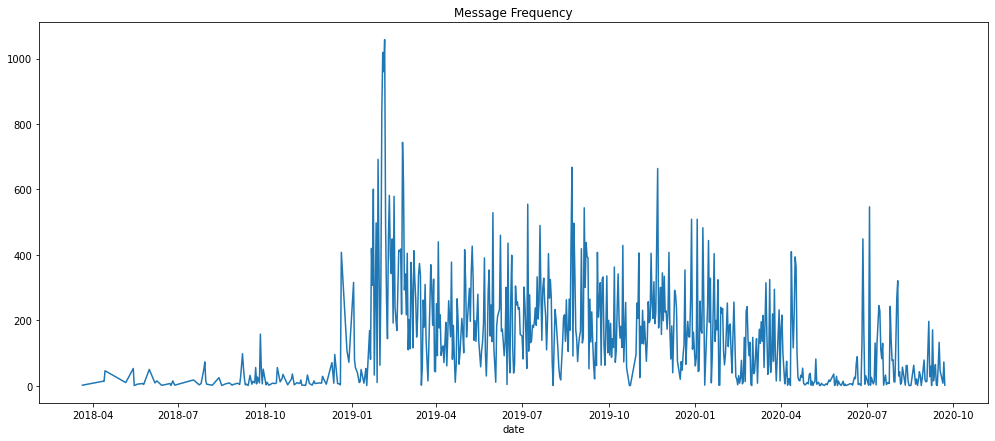

In [41]:
chat.groupby(['date']).count()['msg'].plot(figsize=(17,7),title=f'Message Frequency');

In [42]:
def chat_filter_date(df):
    start_date = parser.parse(input("Enter start date: "))
    end_date = parser.parse(input("Enter end date: "))
    df_filtered = df.filter_date('date',start_date, end_date)[['date','name','msg']]
    return df_filtered.head(10)

In [52]:
chat_filter_date(chat)

Enter start date: 20 august 2018
Enter end date: 30 sep 2018


,date,name,msg
464,2018-08-20,A.,Heya you in today?
465,2018-08-20,👻,"Nope, won't be in today, was up most of the ni..."
466,2018-08-20,👻,I may be the one with the ibs...
467,2018-08-20,A.,"HAHA oh dear, rest well!!"
468,2018-08-20,A.,"What happened, ate smth wrong ?"
469,2018-08-20,👻,"No idea, I didn't eat much"
470,2018-08-24,A.,Hey! Meeting for cancelled
471,2018-08-24,A.,Where is fun toast ah
472,2018-08-24,👻,Nop
473,2018-08-24,👻,Coffee and toast


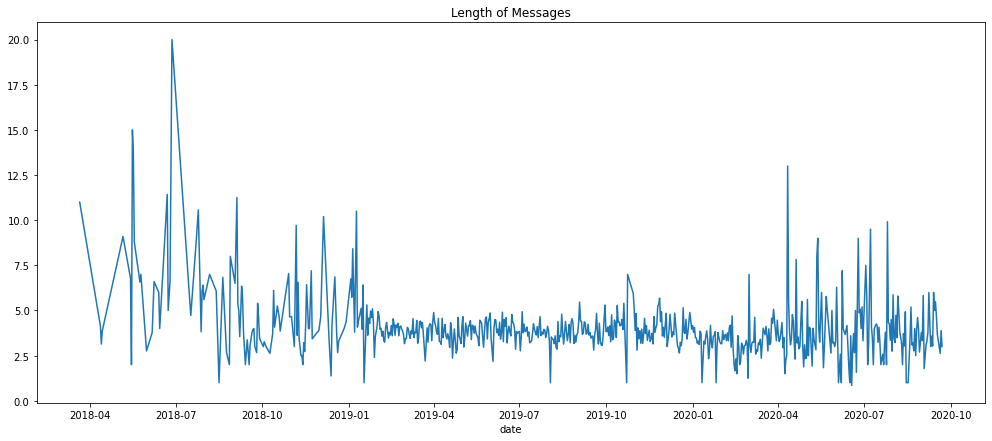

In [44]:
chat.groupby(['date'])['msg_len'].mean().plot(figsize=(17,7),title=f'Length of Messages');

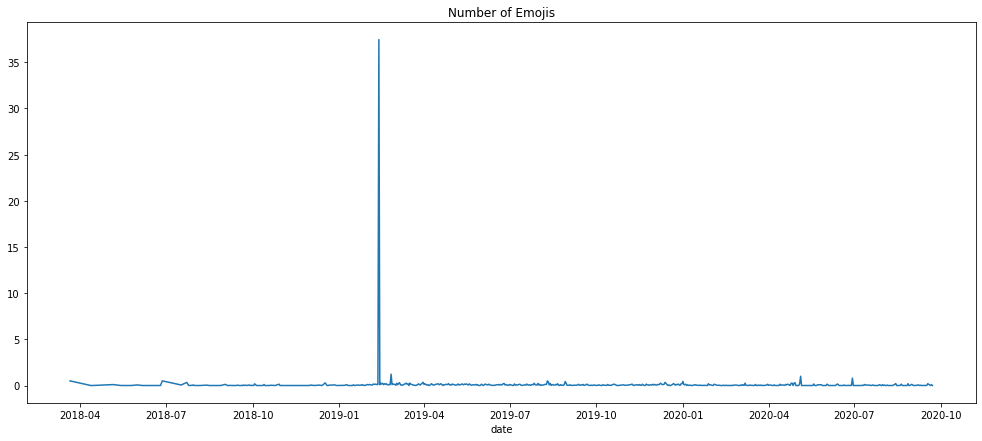

In [45]:
chat.groupby(['date'])['emoji_count'].mean().plot(figsize=(17,7),title=f'Number of Emojis');

In [46]:
chat.groupby(['date'])['emoji_count'].mean().sort_values(ascending=False)

date
2019-02-12    37.45481
2019-02-25     1.22560
2020-05-05     1.00000
2020-06-29     0.80000
2018-03-21     0.50000
                ...   
2020-06-04     0.00000
2020-06-06     0.00000
2020-06-07     0.00000
2020-06-09     0.00000
2020-09-22     0.00000
Name: emoji_count, Length: 680, dtype: float64

In [47]:
def chat_filter_emoji(df):
    lower = int(input("Enter Emoji Lower Range: ") or 0)
    upper = int(input("Enter Emoji Upper Range: ") or df['emoji_count'].max())
    
    df_filtered = chat[(chat['emoji_count'] < upper) & (chat['emoji_count'] > lower)][['date','name','msg','emoji_count']].sort_values(by='emoji_count',ascending=False)
    return df_filtered.head(10)

In [54]:
chat_filter_emoji(chat)

KeyboardInterrupt: 

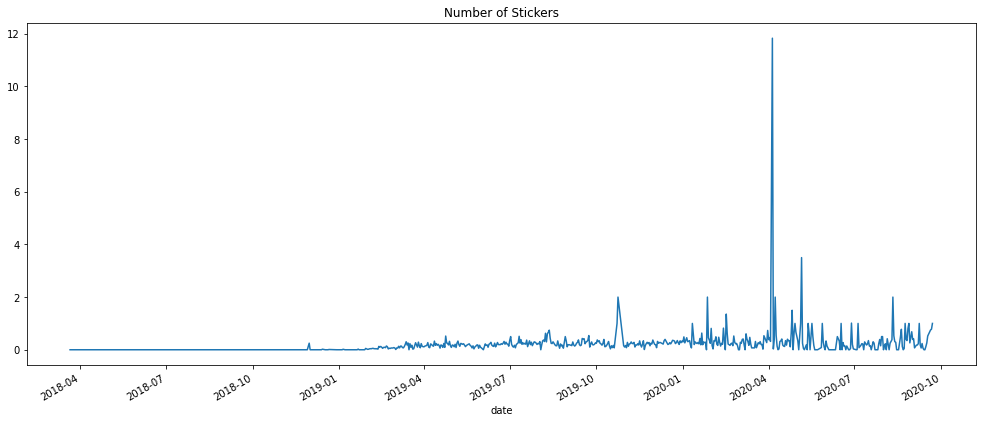

In [55]:
chat.groupby(['date'])['sticker_count'].mean().plot(figsize=(17,7),title=f'Number of Stickers');

In [ ]:
def chat_filter_sticker(df):
    lower = int(input("Enter Sticker Lower Range: ") or 0)
    upper = int(input("Enter Sticker Upper Range: ") or df['sticker_count'].max())
    
    df_filtered = chat[(chat['sticker_count'] < upper) & (chat['sticker_count'] > lower)][['date','name','msg','sticker_count']].sort_values(by='sticker_count',ascending=False)
    return df_filtered.head(10)

In [ ]:
chat_filter_sticker(chat)

## Vectorizing 

In [56]:
cvec = CountVectorizer(stop_words = stop_list)

### N-gram = 1

In [57]:
cvec_msg = cvec.fit_transform(chat['msg_cleaned'])
cvec_msg = pd.DataFrame(cvec_msg.toarray(), columns = cvec.get_feature_names())

In [58]:
cvec_msg_words = cvec_msg.sum().sort_values(ascending=False)
cvec_msg_words.head(10)

dear     4128
ok       3116
im       2816
just     2280
want     2182
haha     2057
think    1880
like     1815
love     1801
dont     1718
dtype: int64

### N-gram = 2/3

In [59]:
cvec23 = CountVectorizer(stop_words = stop_list,
                         ngram_range=(2,3),
                        max_features=10000)

In [60]:
cvec_msg_23 = cvec23.fit_transform(chat['msg_cleaned'])
cvec_msg_23 = pd.DataFrame(cvec_msg_23.toarray(), columns = cvec23.get_feature_names())

In [61]:
cvec_msg_words_23 = cvec_msg_23.sum().sort_values(ascending=False)
cvec_msg_words_23.head(10)

dear dear     374
dont want     219
feel like     212
don know      185
dont know     137
silly girl    136
yes mdm       135
dont think    133
rly rly        99
don want       95
dtype: int64

In [62]:
from matplotlib.colors import LinearSegmentedColormap
colors = ["#000000", "#111111", "#101010", "#121212", "#212121", "#222222"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

msg_1 = WordCloud(width = 1200, height = 900, background_color ='white',
                  colormap=cmap).generate_from_frequencies(cvec_msg_words) 

msg_23 = WordCloud(width = 1200, height = 900, background_color ='white',
                  colormap=cmap).generate_from_frequencies(cvec_msg_words_23) 

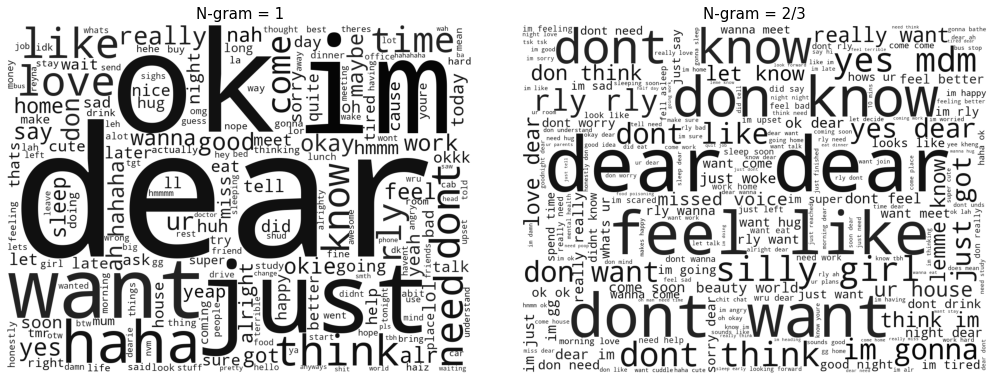

In [63]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 10))
ax[0].imshow(msg_1)
ax[1].imshow(msg_23)

ax[0].set_title('N-gram = 1',size=15)
ax[1].set_title('N-gram = 2/3',size=15)

ax[0].axis('off')
ax[1].axis('off')

plt.tight_layout(pad=5)